In [4]:
import torch
from torch import nn
from torch import Tensor

In [5]:
class ToImage2D(nn.Module):

    def __init__(self, size: int):
        super().__init__()
        self.size = size

    def forward(self, values: Tensor, coord: Tensor):

        size = self.size
        batch = coord.shape[0]

        coord_0 = coord[:, :, 0]
        coord_0_f = coord_0.floor().type(torch.int64)
        coord_0_c = coord_0.ceil().type(torch.int64)

        coord_1 = coord[:, :, 1]
        coord_1_f = coord_1.floor().type(torch.int64)
        coord_1_c = coord_1.ceil().type(torch.int64)

        indexes_ff = coord_0_f * size + coord_1_f
        indexes_fc = coord_0_f * size + coord_1_c
        indexes_cf = coord_0_c * size + coord_1_f
        indexes_cc = coord_0_c * size + coord_1_c

        diff0c = (coord_0 - coord_0_c).abs()
        diff0c[coord_0_c == coord_0_f] = 1
        diff1c = (coord_1 - coord_1_c).abs()
        diff1c[coord_1_c == coord_1_f] = 1

        prob_ff = diff0c * diff1c * values
        prob_fc = diff0c * (coord_1 - coord_1_f).abs() * values
        prob_cf = (coord_0 - coord_0_f).abs() * diff1c * values
        prob_cc = (coord_0 - coord_0_f).abs() * (coord_1 - coord_1_f).abs() * values

        img = torch.zeros([batch, size * size], dtype=torch.float32, device=coord.device)
        img.scatter_add_(1, indexes_ff, prob_ff)
        img.scatter_add_(1, indexes_fc, prob_fc)
        img.scatter_add_(1, indexes_cf, prob_cf)
        img.scatter_add_(1, indexes_cc, prob_cc)

        return img.view(batch, 1, size, size)

In [19]:
coords = torch.ones((3, 10, 2))
values = torch.zeros((3, 10))/10

In [26]:
ToImage2D(20)(values, coords * 19)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

In [71]:
from torch import Tensor
import numpy as np

In [248]:
class ToHeatMap:
    def __init__(self, size):
        self.size = size
    def forward(self, values:Tensor, coord: Tensor):
        B, N, D = coord.shape

        coord_0 = coord[:, :, 0]
        coord_0_f = coord_0.floor().type(torch.int64)
        coord_0_c = coord_0.ceil().type(torch.int64)

        coord_1 = coord[:, :, 1]
        coord_1_f = coord_1.floor().type(torch.int64)
        coord_1_c = coord_1.ceil().type(torch.int64)

        diff0c = (coord_0 - coord_0_c).abs()
        diff0c[coord_0_c == coord_0_f] = 1
        diff1c = (coord_1 - coord_1_c).abs()
        diff1c[coord_1_c == coord_1_f] = 1

        prob_ff = diff0c * diff1c * values
        prob_fc = diff0c * (coord_1 - coord_1_f).abs() * values
        prob_cf = (coord_0 - coord_0_f).abs() * diff1c * values
        prob_cc = (coord_0 - coord_0_f).abs() * (coord_1 - coord_1_f).abs() * values

        tmp = torch.zeros(B, N * self.size * self.size, device=coord.device)
        tmp.scatter_add_(1, torch.arange(N)[None,:] * self.size ** 2 + coord_1_f * self.size + coord_0_f, prob_ff) #prob_ff)
        tmp.scatter_add_(1, torch.arange(N)[None,:] * self.size ** 2 + coord_1_c * self.size + coord_0_f, prob_cf) #prob_fc)
        tmp.scatter_add_(1, torch.arange(N)[None,:] * self.size ** 2 + coord_1_f * self.size + coord_0_c, prob_fc) #prob_cf)
        tmp.scatter_add_(1, torch.arange(N)[None,:] * self.size ** 2 + coord_1_c * self.size + coord_0_c, prob_cc) #prob_cc)
        
        return tmp.reshape((B, N, self.size, self.size))


In [258]:
def final_preds_untransformed(output, res):
    coords = get_preds(output) # float type

    # pose-processing
    for n in range(coords.size(0)):
        for p in range(coords.size(1)):
            hm = output[n][p]
            px = int(math.floor(coords[n][p][0]))
            py = int(math.floor(coords[n][p][1]))
            if px > 1 and px < res[0] and py > 1 and py < res[1]:
                diff = torch.tensor([hm[py - 1][px] - hm[py - 1][px - 2], hm[py][px - 1]-hm[py - 2][px - 1]], device=output.device)
                coords[n][p] += diff.sign() * .25
    coords += 0.5

    if coords.dim() < 3:
        coords = coords.unsqueeze(0)

    coords -= 1  # Convert from 1-based to 0-based coordinates

    return coords


def get_preds(scores):
    ''' get predictions from score maps in torch Tensor
        return type: torch.LongTensor
    '''
    assert scores.dim() == 4, 'Score maps should be 4-dim'
    maxval, idx = torch.max(scores.view(scores.size(0), scores.size(1), -1), 2)

    maxval = maxval.view(scores.size(0), scores.size(1), 1)
    idx = idx.view(scores.size(0), scores.size(1), 1) + 1

    preds = idx.repeat(1, 1, 2).float()

    preds[:,:,0] = (preds[:,:,0] - 1) % scores.size(3) + 1
    preds[:,:,1] = torch.floor((preds[:,:,1] - 1) / scores.size(3)) + 1

    pred_mask = maxval.gt(0).repeat(1, 1, 2).float()
    preds *= pred_mask
    return preds

In [264]:
import math
coordici = final_preds_untransformed(res, (100,100))

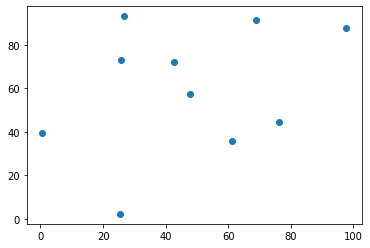

In [265]:
plt.scatter(coordici[0,:,0].numpy(),coordici[0,:,1].numpy())

In [249]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage import rotate
# from scipy.misc import imread, imshow

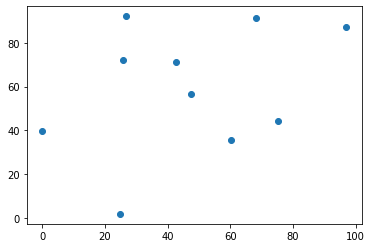

In [250]:
batch_size, N, size = 5, 10, 100
prob = torch.randn(batch_size, N).abs()
coord = torch.randint(0, 100, (batch_size, N, 2)) * 0.99
plt.scatter(coord[0,:,0].numpy(),coord[0,:,1].numpy())
res = ToHeatMap(100).forward(prob, coord)

In [251]:
coord[0,2]

tensor([42.5700, 71.2800])

In [255]:
res[0][0].sum()

tensor(0.0565)

(100, 100)


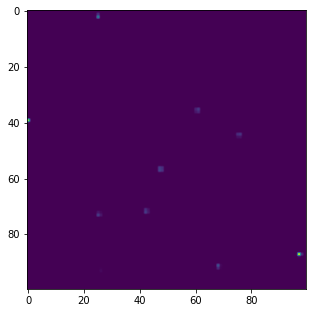

In [252]:
plt.figure(figsize=(5,10))
print(res[0].sum(dim=0).numpy().shape)
# plt.imshow(scipy.ndimage.rotate(res[0].sum(dim=0).numpy(), 90))
# torch.rot90(x, 1, [0, 1])
plt.imshow(res[0].sum(dim=0).numpy())

In [170]:
res.shape

torch.Size([5, 10, 120, 120])

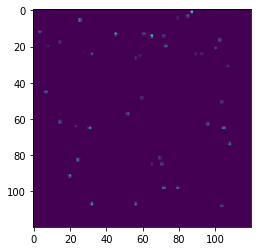

In [88]:
plt.imshow(res[0].sum(dim=0).numpy())


In [24]:
batch_size, N, size = 5, 10, 20
prob = torch.randn(batch_size, N)
print(prob.shape)
landmarks = torch.randint(0, size, (batch_size, N, 2))
print('landmarks, shape', landmarks.shape)
rows, cols = landmarks[..., 0], landmarks[..., 1] #,torch.split(landmarks, 1, 2)
print('rows shape', rows.shape)
print('cols shape', cols.shape)
tmp = torch.zeros(batch_size, N, size, size)
print('tmp shape', tmp.shape)
tmp[:, :, rows, cols] = prob
print('tmp shape', tmp.shape)

torch.Size([5, 10])
landmarks, shape torch.Size([5, 10, 2])
rows shape torch.Size([5, 10])
cols shape torch.Size([5, 10])
tmp shape torch.Size([5, 10, 20, 20])
tmp shape torch.Size([5, 10, 20, 20])


In [25]:
landmarks[0]

tensor([[ 9, 10],
        [ 1, 16],
        [ 9, 12],
        [14, 10],
        [ 2,  7],
        [ 2,  5],
        [ 3, 16],
        [ 2,  2],
        [ 8,  1],
        [14,  5]])

In [26]:
prob[0,2]

tensor(0.1832)

In [27]:
tmp[0][0][9][12]

tensor(0.1832)

In [88]:
print(landmarks)

tensor([[[ 0,  2],
         [ 8, 16],
         [14,  5],
         [12,  7],
         [ 1,  4],
         [15, 10],
         [ 8,  9],
         [16,  0],
         [ 0,  9],
         [ 5,  2]],

        [[ 7,  9],
         [19,  3],
         [ 5, 13],
         [ 0, 19],
         [19, 17],
         [ 6,  3],
         [16, 11],
         [11, 11],
         [ 5, 18],
         [18,  0]],

        [[ 7, 16],
         [16,  3],
         [ 2,  1],
         [ 4, 19],
         [ 8, 13],
         [13, 15],
         [17,  4],
         [ 2,  4],
         [ 4, 12],
         [ 4, 13]],

        [[ 0,  7],
         [16, 15],
         [ 4, 13],
         [15, 15],
         [10,  3],
         [ 7, 12],
         [ 4,  5],
         [ 8,  1],
         [ 4, 11],
         [10,  1]],

        [[ 2,  4],
         [ 5, 17],
         [14, 18],
         [14,  0],
         [ 1,  8],
         [17,  3],
         [12,  3],
         [ 9, 18],
         [ 1,  7],
         [ 6, 13]]])


In [76]:
listochek[0].shape

torch.Size([5, 10, 1])

In [55]:
rows, cols = landmarks.split()
print(rows.shape)
print(cols.shape)

TypeError: split() takes from 2 to 3 positional arguments but 4 were given

In [ ]:
tmp = torch.zeros(N, 3, H, W)

In [53]:
landmarks.shape

torch.Size([5, 10, 2])

In [38]:
landmarks[0]

tensor([4, 8])

In [41]:
print(landmarks)

tensor([[4, 8],
        [5, 8],
        [6, 1],
        [3, 0],
        [5, 1],
        [1, 0],
        [6, 6],
        [5, 8],
        [3, 0],
        [3, 5],
        [7, 0],
        [8, 3]])


In [42]:
landmarks.split(1, 1)

(tensor([[4],
         [5],
         [6],
         [3],
         [5],
         [1],
         [6],
         [5],
         [3],
         [3],
         [7],
         [8]]),
 tensor([[8],
         [8],
         [1],
         [0],
         [1],
         [0],
         [6],
         [8],
         [0],
         [5],
         [0],
         [3]]))

In [2]:
sys.path

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/ibespalov/venv/lib/python3.6/site-packages',
 '/home/ibespalov/venv/lib/python3.6/site-packages/geomloss-0.2.3-py3.6.egg',
 '/home/ibespalov/venv/lib/python3.6/site-packages/IPython/extensions',
 '/home/ibespalov/.ipython',
 '/usr/lib/python36.zip/../',
 '/usr/lib/python36.zip/../dataset',
 '/usr/lib/python36.zip/../gans_pytorch/',
 '/usr/lib/python36.zip/../gans_pytorch/stylegan2',
 '/usr/lib/python36.zip/../gans_pytorch/gan/']